Here we will work on gathering the data using the Jira API to build our CSV with a larger dataset

In [37]:
import requests
import json
import pandas as pd
from tqdm import tqdm
import os
from dotenv import load_dotenv  # Add python-dotenv for better env management

load_dotenv
BEARER_TOKEN = os.getenv('JIRA_BEARER_TOKEN')
JIRA_URL = 'https://csc.cioxhealth.com'
 
session = requests.Session()
session.headers.update({
    'Authorization': f'Bearer {BEARER_TOKEN}',
    'Content-Type': 'application/json'  # Ensure Content-Type is set to application/json
    })

def login_to_jira():
    response = session.get(JIRA_URL + '/rest/api/2/user?username=SVC_IT_Automation')
    
    if response.status_code == 200:
        print("Successfully logged in to Jira")
        #print(response.json())
        return True
    else:
        print("Failed to log in to Jira")
        print(response.status_code, response.text)
        return False


# Login to JIRA
if not login_to_jira():
    raise Exception("Failed to log in to JIRA")

Successfully logged in to Jira


In [ ]:
# Data retrieval variables
start_at = 0
max_results = 100
total = None
fields = ['key', 'project', 'summary', 'description', 'assignee', 'httpUrl', 'customfield_19900', 'customfield_15404', 'customfield_14201']
issues_list = []

# Prepare for progress bar
pbar = tqdm(total=None)  # Total will be updated after first response

# Main loop for data retrieval
while total is None or start_at < total:
    search_data = {
        'jql': "project='29-IT Service Desk' AND status=closed AND created >= startOfYear(-1y)",
        'fields': fields,
        'startAt': start_at,
        'maxResults': max_results
    }

    search_response = session.post(
        f"{JIRA_URL}/rest/api/2/search",
        data=json.dumps(search_data),
        timeout=300
    )

    if search_response.status_code == 200:
        search_result = search_response.json()
        if 'issues' in search_result:
            issues_list.extend(search_result['issues'])

        if total is None:
            total = search_result['total']
            pbar.total = total // max_results + (total % max_results > 0)
            pbar.refresh()

        start_at += max_results
        pbar.update(1)

    elif search_response.status_code == 401:
        if not login_to_jira():
            print("Failed to re-authenticate.")
            break

    else:
        print("Received unexpected status code:", search_response.status_code)
        print(search_response.text)
        break

pbar.close()

# Convert collected data to DataFrame
df = pd.json_normalize(issues_list)

We'll save the dataframe to a CSV so that we have a saved copy incase something happens so we don't have to redownload it again.

In [2]:
import datetime

# Save DataFrame to CSV
now = datetime.datetime.now()
df.to_csv(f'dataframe{now:%Y-%m-%d_%H-%M}.csv', index=False)

Lets look at the size and a sample of our dataframe we'll be working with

In [ ]:
size = len(df)
print(f"Dataframe Size: {size:.2f}KB")

print(df.columns)
print(df.sample(5))

Verify GPU


In [2]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Set device to the first CUDA device
    device = torch.device("cuda:0")
    print(f"Using device: {torch.cuda.get_device_name(0)}")

    # Create random tensors
    x = torch.randn(5000, 5000, device=device)
    y = torch.randn(5000, 5000, device=device)

    # Perform matrix multiplication
    print("Performing matrix multiplication on GPU...")
    z = torch.matmul(x, y)

    # The operation is performed on the GPU, so if this script runs without errors
    # and you observe the GPU utilization go up in your system's resource monitor,
    # then the Nvidia A1000 is being used.
    print("Done with matrix multiplication.")

else:
    print("CUDA is not available. Using CPU instead.")


Using device: NVIDIA GeForce RTX 3090
Performing matrix multiplication on GPU...
Done with matrix multiplication.


This cell is used to reload the dataframe from the CSV

In [28]:
import pandas as pd
# Load CSV
df = pd.read_csv('dataframe2.csv')
print(len(df))

322600


In [4]:
# Remove unneeded columns
df = df[[
    'fields.customfield_14201',
    'fields.assignee.displayName',
    'fields.customfield_15404.value',
    'fields.summary',
    'fields.description'
]]

We need to rename the columns to make it more easily understandable

Rename columns

In [5]:
df = df.rename(columns={
    'fields.customfield_14201':'Category 1',
    'fields.assignee.displayName':'Assignee',
    'fields.customfield_15404.value':'IT Group',
    'fields.summary':'Summary',
    'fields.description':'Description'
})

Data Cleaning

In [8]:
import nltk
from nltk.corpus import stopwords
import re

# Download only stopwords if needed
nltk.download('stopwords')

def clean_text(text):
    if not isinstance(text, str):
        return ''
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    # Remove stopwords - using simple split() instead of word_tokenize
    stop_words = set(stopwords.words('english'))
    words = text.split()
    text = ' '.join([w for w in words if w not in stop_words])
    
    return text

# Clean Summary and Description fields
df['Summary'] = df['Summary'].apply(clean_text)
df['Description'] = df['Description'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
print(df.columns)
print(df.sample(5))

Index(['Category 1', 'Assignee', 'IT Group', 'Summary', 'Description'], dtype='object')
                                               Category 1            Assignee  \
124340  [{'self': 'https://csc.cioxhealth.com/rest/api...      Michael Nemitz   
216723  [{'self': 'https://csc.cioxhealth.com/rest/api...   SVC_IT_Automation   
259664  [{'self': 'https://csc.cioxhealth.com/rest/api...   SVC_IT_Automation   
237468  [{'self': 'https://csc.cioxhealth.com/rest/api...      Andrew Cargill   
5890    [{'self': 'https://csc.cioxhealth.com/rest/api...  Karthik Padmarajan   

                    IT Group  \
124340  Product Support (PS)   
216723                   NaN   
259664                   NaN   
237468                  ITSD   
5890       App- Corp Systems   

                                                  Summary  \
124340                  need erids kicked back fulfilment   
216723  access new sites formerly heidi formosa yvette...   
259664                   healthsource site access

This is to clean up the code, removing all NaN rows as well as all ITSD rows so only properly assigned tickets are in place.

In [10]:
#drop all rows with IT Group = NaN
df = df.dropna(subset=['IT Group'])

#drop all ITSD tickets
df = df[df['IT Group'] != 'ITSD']

In [11]:
df['IT Group'].unique()

array(['DCO', 'DTO', 'HealthSource CX', 'App- Corp Systems', 'App- CDAI',
       'Privacy Hub', 'App- CRI', 'ReChase', 'SOC', 'Request Fulfillment',
       'Digital Grid', 'M365', 'Telecom', 'Enterprise Tools', 'EUS',
       'BI Reporting CDAI', 'ARCH', 'NETWORK', 'IT Software Licensing',
       'Business Intelligence CRI', 'Healthsource', 'Virtualization',
       'CorpSys - Coupa', 'IAM', 'DBA', 'App-SmartRequest/Record Hub',
       'Automation (RPA)', 'Infra Engineering', 'CorpSys - NetSuite',
       'Desktop Engineering', 'HCM', 'Product Support (PS)', 'Salesforce',
       'Red Team', 'Healthcare Integration', 'EDELIVERY',
       'App-Arch Support', 'Print Eng', 'PMO', 'CRS'], dtype=object)

Analyze Class Distribution

Class distribution:
IT Group
Product Support (PS)           34759
DTO                            29942
DCO                            18326
Request Fulfillment            16842
App- Corp Systems               8997
App- CDAI                       8326
HealthSource CX                 6691
ReChase                         5368
App- CRI                        4787
M365                            4224
Digital Grid                    2529
Telecom                         2412
SOC                             1792
IAM                             1617
IT Software Licensing           1349
NETWORK                         1259
EUS                              896
Enterprise Tools                 860
BI Reporting CDAI                821
App-SmartRequest/Record Hub      631
Virtualization                   623
DBA                              600
Infra Engineering                480
Business Intelligence CRI        441
Desktop Engineering              150
Healthcare Integration           122
CorpSys -

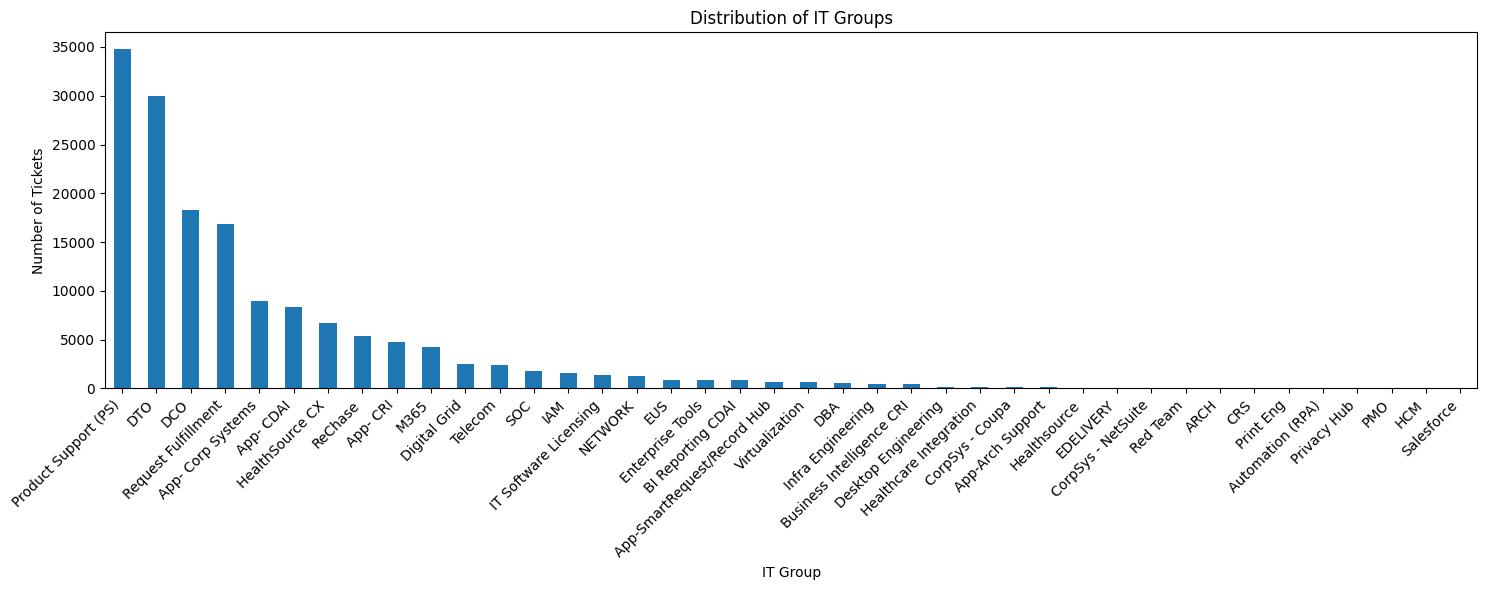

In [12]:
# Analyze class distribution
print("Class distribution:")
print(df['IT Group'].value_counts())
print("\nPercentage distribution:")
print(df['IT Group'].value_counts(normalize=True) * 100)

# Visualize the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
df['IT Group'].value_counts().plot(kind='bar')
plt.title('Distribution of IT Groups')
plt.xlabel('IT Group')
plt.ylabel('Number of Tickets')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Lets normalize the data so that the classes are more balanced

In [13]:
print("\nCreating balanced dataset for baseline model...")
group_counts = df['IT Group'].value_counts()
min_acceptable_samples = 500
print(f"\nOriginal class distribution:")
print(group_counts)

valid_groups = group_counts[group_counts >= min_acceptable_samples].index
df_filtered = df[df['IT Group'].isin(valid_groups)]
print(f"\nRemoved {len(group_counts) - len(valid_groups)} classes with fewer than {min_acceptable_samples} samples")

balanced_dfs = []
samples_per_class = min_acceptable_samples
for group in valid_groups:
    group_df = df_filtered[df_filtered['IT Group'] == group]
    if len(group_df) < samples_per_class * 1.5:
        n_samples = int(len(group_df) * 0.8)
    else:
        n_samples = samples_per_class
    sampled_df = group_df.sample(n=n_samples, random_state=42)
    balanced_dfs.append(sampled_df)

df_balanced = pd.concat(balanced_dfs, ignore_index=True)

print("\nFinal balanced dataset statistics:")
print(f"Total samples: {len(df_balanced)}")
print("\nSamples per class:")
print(df_balanced['IT Group'].value_counts())

df = df_balanced
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


Creating balanced dataset for baseline model...

Original class distribution:
IT Group
Product Support (PS)           34759
DTO                            29942
DCO                            18326
Request Fulfillment            16842
App- Corp Systems               8997
App- CDAI                       8326
HealthSource CX                 6691
ReChase                         5368
App- CRI                        4787
M365                            4224
Digital Grid                    2529
Telecom                         2412
SOC                             1792
IAM                             1617
IT Software Licensing           1349
NETWORK                         1259
EUS                              896
Enterprise Tools                 860
BI Reporting CDAI                821
App-SmartRequest/Record Hub      631
Virtualization                   623
DBA                              600
Infra Engineering                480
Business Intelligence CRI        441
Desktop Engineering     

This reduces the dataset to be 20% of the original to fit within memory constraints


In [10]:

#reducing size of dataset
df = df.sample(frac=0.2,random_state=42)

Now we start our work.  We load the dataframe from the CSV, and we'll start filling in empty fields to prevent errors

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import gc

# Combine 'Summary', 'Description', and 'Last Comment Assignee' into one field
#df['combined'] = df[['Summary', 'Description', 'Last Comment Assignee']].fillna('').agg(' '.join, axis=1)
df['combined'] = df[['Summary', 'Description']].fillna('').agg(' '.join, axis=1)

# Drop the original fields
#df = df.drop(['Summary', 'Description', 'Last Comment Assignee'], axis=1)
#df = df.drop(['Summary', 'Description'], axis=1)

# Fill in the blank values in 'IT Group', 'Assignee', 'Category 1', 'Category 2', and 'Category 3'
imputer = SimpleImputer(strategy='constant', fill_value='unknown')
#df[['IT Group', 'Assignee', 'Category 1', 'Category 2', 'Category 3']] = imputer.fit_transform(df[['IT Group', 'Assignee', 'Category 1', 'Category 2', 'Category 3']])
df[['IT Group', 'Assignee', 'Category 1']] = imputer.fit_transform(df[['IT Group', 'Assignee', 'Category 1']])

In [15]:
import gc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert data types for memory efficiency
# df = df.astype({'col_name': 'category', 'int_col': 'int32', ...})



# Create and fit label encoders
le_it_group = LabelEncoder()
#le_assignee = LabelEncoder()
df['IT Group'] = le_it_group.fit_transform(df['IT Group'])
#df['Assignee'] = le_assignee.fit_transform(df['Assignee'])
print("Label Encoders Completed")

# Drop original columns if they are no longer needed
#df.drop(['IT Group', 'Assignee'], axis=1, inplace=True)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['combined'], df[['IT Group', 'Assignee']], test_size=0.2, random_state=42)
print("Train/Test split completed")

# Create a pipeline for each category
pipeline_it_group = Pipeline([('tfidf', TfidfVectorizer(max_features=10000)), ('clf', RandomForestClassifier(n_jobs=-1))])
#pipeline_assignee = Pipeline([('tfidf', TfidfVectorizer(max_features=10000)), ('clf', RandomForestClassifier(n_jobs=-1))])
print("Pipelines created")

# Train the models
pipeline_it_group.fit(X_train, y_train['IT Group'])
#pipeline_assignee.fit(X_train, y_train['Assignee'])
print("Training Completed")

# Clear memory
gc.collect()


Label Encoders Completed
Train/Test split completed
Pipelines created
Training Completed


8933

Creates a grid search to find the best parameters for the model

In [16]:
from sklearn.model_selection import GridSearchCV

# Keep our existing TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=15000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.95,
    strip_accents='unicode',
    sublinear_tf=True
)

# Create base pipeline
base_pipeline = Pipeline([
    ('tfidf', tfidf),
    ('clf', RandomForestClassifier(
        n_jobs=-1,
        class_weight='balanced',
        random_state=42  # Add for reproducibility
    ))
])

# Expanded parameter grid
param_grid = {
    'clf__n_estimators': [200, 300, 400],
    'clf__max_depth': [20, 30, 40],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__max_features': ['sqrt', 'log2'],  # Add feature selection strategy
    'clf__bootstrap': [True, False]  # Add bootstrap sampling option
}

# Create and train grid search
grid_search = GridSearchCV(
    base_pipeline,
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'  # Explicitly set scoring metric
)

print("Starting grid search...")
grid_search.fit(X_train, y_train['IT Group'])

print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Use the best model
pipeline_it_group = grid_search.best_estimator_

Starting grid search...
Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=sqrt, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200; total time=   6.5s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=sqrt, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200; total time=   6.7s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=200; total time=   6.8s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=200; total time=   7.0s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=200; total time=   7.2s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=sqrt, clf__min_s

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Best parameters: {'clf__bootstrap': True, 'clf__max_depth': 40, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 400}
Best cross-validation score: 0.7056341304000382


# RoBERTa Implementation
Here we'll implement RoBERTa as an alternative model for comparison with RandomForest and XGBoost.
We'll use the transformers library to load and fine-tune RoBERTa on our ticket classification task.

In [52]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import tqdm as notebook_tqdm

# Initialize tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=len(le_it_group.classes_),  # Number of IT groups
    output_attentions=False,
    output_hidden_states=False,
)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Create dataset class
class TicketDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(texts, truncation=True, padding=True, 
                                 max_length=max_length, return_tensors='pt')
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Prepare data
train_texts = X_train.tolist()
train_labels = y_train['IT Group'].tolist()  # Using encoded labels

# Create datasets
train_dataset = TicketDataset(train_texts, train_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Training configuration
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 3

# Training loop
model.train()
for epoch in range(epochs):
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}')
    
    for batch in progress_bar:
        optimizer.zero_grad()
        
        # Move batch to GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.3f}'})
    
    avg_loss = total_loss / len(train_loader)
    print(f'\nEpoch {epoch + 1} average loss: {avg_loss:.3f}')

# Add prediction function for RoBERTa
def predict_with_roberta(text):
    model.eval()
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=-1)
        
        predicted_class = torch.argmax(probs, dim=-1).cpu().numpy()[0]
        confidence_score = probs.max().item()
        
        predicted_group = le_it_group.inverse_transform([predicted_class])[0]
        
        return predicted_group, confidence_score

# Save the model
model_name = 'roberta_classifier'
model_path = f'{model_name}_model.pth'
torch.save(model.state_dict(), model_path)
print(f"Saved {model_name} model to {model_path}")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 1099/1099 [03:31<00:00,  5.20it/s, loss=0.212]



Epoch 1 average loss: 1.487


Epoch 2: 100%|██████████| 1099/1099 [03:32<00:00,  5.17it/s, loss=0.069]



Epoch 2 average loss: 0.822


Epoch 3: 100%|██████████| 1099/1099 [03:33<00:00,  5.16it/s, loss=0.055]



Epoch 3 average loss: 0.632
Saved roberta_classifier model to roberta_classifier_model.pth


Evaluate the RoBERTa Model

Evaluating RoBERTa model...


100%|██████████| 2197/2197 [00:13<00:00, 160.71it/s]



RoBERTa Model Evaluation Results:
Overall Accuracy: 0.7474

Classification Report:
                             precision    recall  f1-score   support

                  App- CDAI       0.94      0.83      0.88        89
                   App- CRI       0.75      0.58      0.65       116
          App- Corp Systems       0.85      0.70      0.77       121
App-SmartRequest/Record Hub       0.84      0.89      0.86       111
          BI Reporting CDAI       0.87      0.84      0.85        93
                        DBA       0.75      0.94      0.84        89
                        DCO       0.91      0.90      0.90        98
                        DTO       0.33      0.44      0.38        91
               Digital Grid       0.96      0.92      0.94       103
                        EUS       0.69      0.80      0.74        99
           Enterprise Tools       0.93      0.78      0.85       105
            HealthSource CX       0.45      0.56      0.50        89
                  

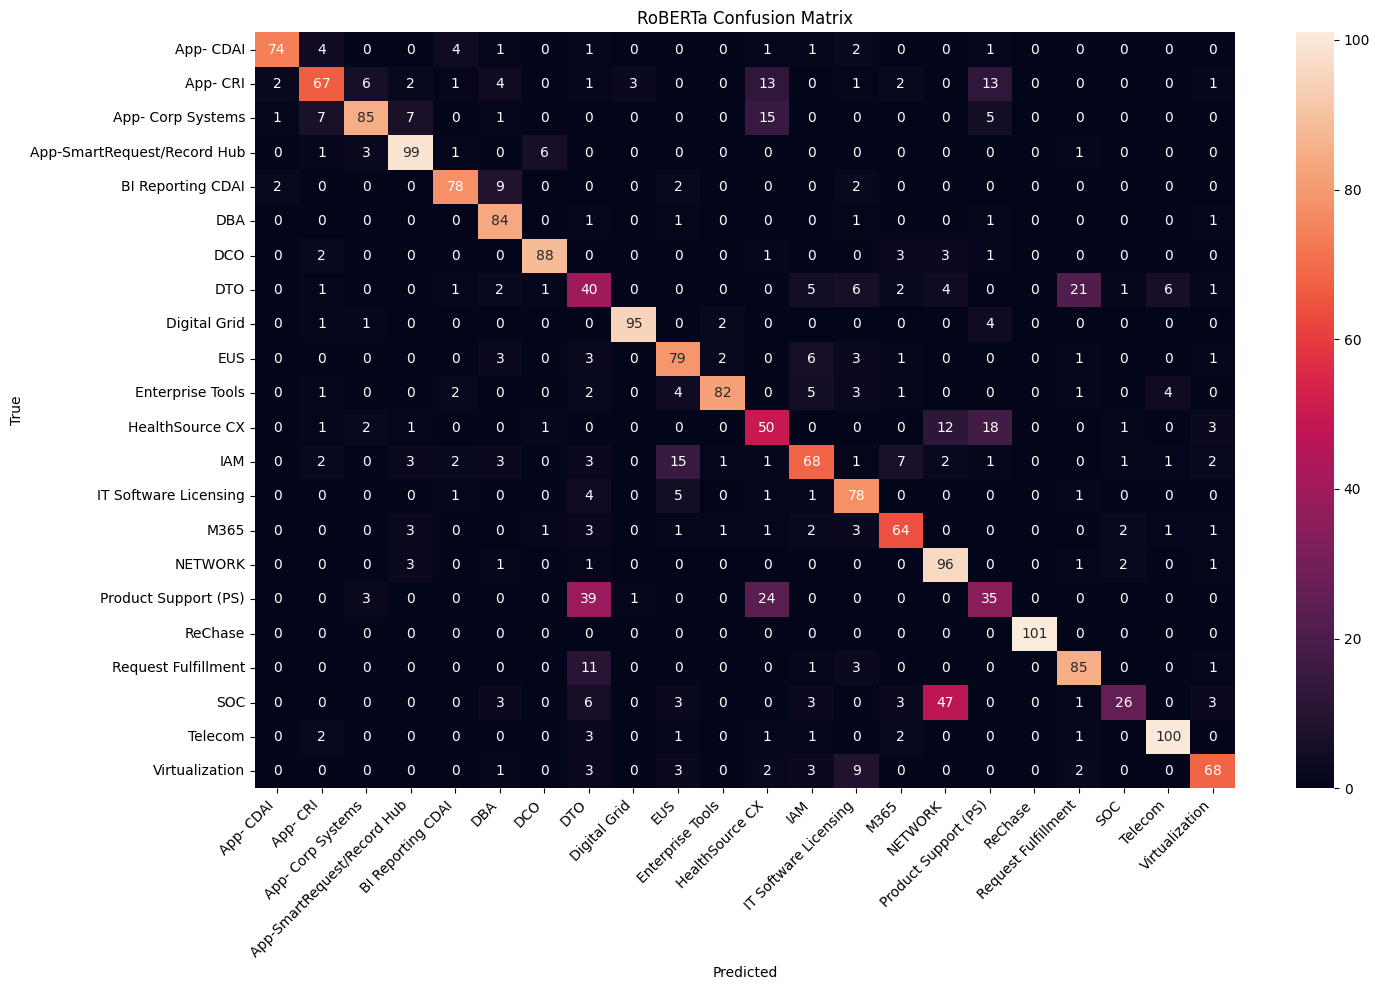

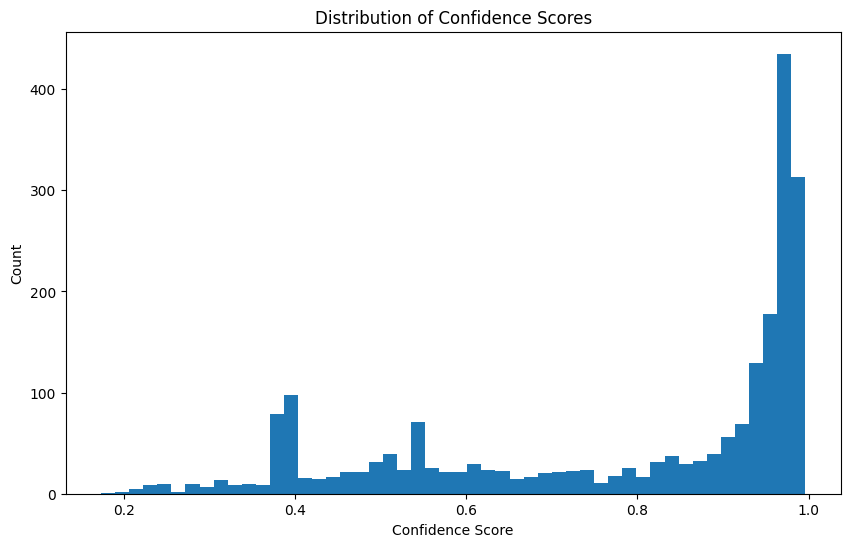

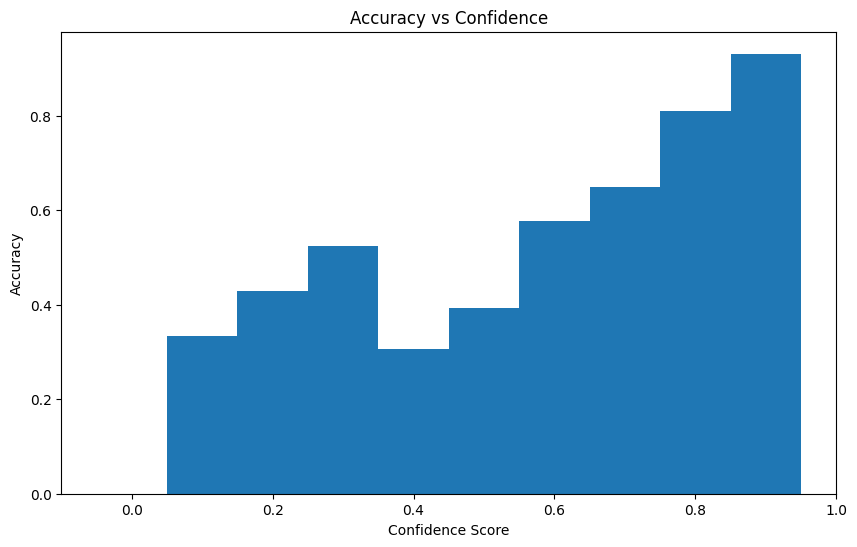


Model Comparison:
RoBERTa Accuracy: 0.7474
Random Forest Accuracy: 0.7051

Top misclassification patterns:
True: SOC                  Predicted: NETWORK              Count: 47
True: Product Support (PS) Predicted: DTO                  Count: 39
True: Product Support (PS) Predicted: HealthSource CX      Count: 24
True: DTO                  Predicted: Request Fulfillment  Count: 21
True: HealthSource CX      Predicted: Product Support (PS) Count: 18
True: IAM                  Predicted: EUS                  Count: 15
True: App- Corp Systems    Predicted: HealthSource CX      Count: 15
True: App- CRI             Predicted: HealthSource CX      Count: 13
True: App- CRI             Predicted: Product Support (PS) Count: 13
True: HealthSource CX      Predicted: NETWORK              Count: 12


In [53]:
# Evaluation of RoBERTa Model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_roberta():
    """
    Evaluate RoBERTa model performance on test set
    """
    model.eval()  # Set model to evaluation mode
    predictions = []
    true_labels = []
    confidence_scores = []
    
    # Create test dataset
    test_texts = X_test.tolist()
    test_labels = y_test['IT Group'].tolist()
    
    print("Evaluating RoBERTa model...")
    
    # Get predictions for test set
    with torch.no_grad():  # No gradients needed for evaluation
        for text, true_label in tqdm(zip(test_texts, test_labels), total=len(test_texts)):
            # Get prediction
            inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            outputs = model(**inputs)
            probs = F.softmax(outputs.logits, dim=-1)
            
            predicted_class = torch.argmax(probs, dim=-1).cpu().numpy()[0]
            confidence = probs.max().item()
            
            predictions.append(predicted_class)
            true_labels.append(true_label)
            confidence_scores.append(confidence)
    
    # Convert predictions back to group names
    predicted_groups = le_it_group.inverse_transform(predictions)
    true_groups = le_it_group.inverse_transform(true_labels)
    
    # Calculate metrics
    accuracy = accuracy_score(true_groups, predicted_groups)
    class_report = classification_report(true_groups, predicted_groups)
    conf_matrix = confusion_matrix(true_groups, predicted_groups)
    
    # Print results
    print("\nRoBERTa Model Evaluation Results:")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(class_report)
    
    # Plot confusion matrix
    plt.figure(figsize=(15, 10))
    sns.heatmap(conf_matrix, 
                annot=True, 
                fmt='d',
                xticklabels=le_it_group.classes_,
                yticklabels=le_it_group.classes_)
    plt.title('RoBERTa Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Analyze confidence distribution
    plt.figure(figsize=(10, 6))
    plt.hist(confidence_scores, bins=50)
    plt.title('Distribution of Confidence Scores')
    plt.xlabel('Confidence Score')
    plt.ylabel('Count')
    plt.show()
    
    # Analyze accuracy vs confidence
    confidence_bins = np.linspace(0, 1, 11)
    accuracies = []
    counts = []
    
    for i in range(len(confidence_bins)-1):
        mask = (np.array(confidence_scores) >= confidence_bins[i]) & (np.array(confidence_scores) < confidence_bins[i+1])
        if mask.sum() > 0:
            bin_acc = accuracy_score(np.array(true_groups)[mask], np.array(predicted_groups)[mask])
            accuracies.append(bin_acc)
            counts.append(mask.sum())
        else:
            accuracies.append(0)
            counts.append(0)
    
    plt.figure(figsize=(10, 6))
    plt.bar(confidence_bins[:-1], accuracies, width=0.1)
    plt.title('Accuracy vs Confidence')
    plt.xlabel('Confidence Score')
    plt.ylabel('Accuracy')
    plt.show()
    
    # Compare with Random Forest accuracy
    rf_predictions = pipeline_it_group.predict(X_test)
    rf_accuracy = accuracy_score(y_test['IT Group'], rf_predictions)
    
    print("\nModel Comparison:")
    print(f"RoBERTa Accuracy: {accuracy:.4f}")
    print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
    
    # Return metrics for further analysis if needed
    return {
        'accuracy': accuracy,
        'classification_report': class_report,
        'confusion_matrix': conf_matrix,
        'confidence_scores': confidence_scores,
        'predictions': predicted_groups,
        'true_labels': true_groups
    }

# Run evaluation
evaluation_results = evaluate_roberta()

# Additional analysis: Most common misclassifications
def analyze_misclassifications(true_labels, predictions, top_n=10):
    """
    Analyze the most common misclassifications
    """
    misclassifications = []
    for true, pred in zip(true_labels, predictions):
        if true != pred:
            misclassifications.append((true, pred))
    
    # Count misclassification patterns
    from collections import Counter
    misclass_counts = Counter(misclassifications)
    
    print("\nTop misclassification patterns:")
    for (true, pred), count in misclass_counts.most_common(top_n):
        print(f"True: {true:<20} Predicted: {pred:<20} Count: {count}")

# Analyze misclassifications
analyze_misclassifications(evaluation_results['true_labels'], 
                         evaluation_results['predictions'])



This section onward uses the model to predict the IT Group for a ticket in Jira.

First we create a function to search for a ticket in Jira and return the IT Group

In [36]:
def search_jira_ticket(ticket_number):
    if not login_to_jira():
        raise Exception("Failed to log in to JIRA")

    search_data = {
        'jql': f"issue = {ticket_number}",
        'fields': ['summary', 'description', 'assignee', 'customfield_19900', 'customfield_15404', 'customfield_14201'],
        'startAt': 0,
        'maxResults': 1
    }

    search_response = session.post(
        f"{JIRA_URL}/rest/api/2/search",
        data=json.dumps(search_data),
        timeout=300
    )

    if search_response.status_code == 200:
        search_result = search_response.json()
        return pd.json_normalize(search_result['issues'])
    else:
        print("Failed to retrieve the ticket:", search_response.status_code)
        print(search_response.text)
        return None


Here is the function to validate and suggest the IT Group for a ticket in Jira.

In [34]:
def validate_and_suggest_it_group_with_confidence(group_name, confidence_threshold=0.10):
    df_tickets = search_jira_unassigned_tickets_in_group(group_name)
    if df_tickets.empty:
        return "No tickets found or error in retrieval"

    # Create a copy of the dataframe to avoid the warning
    df_tickets = df_tickets.copy()
    
    # Fix the fillna operations
    df_tickets['fields.summary'] = df_tickets['fields.summary'].fillna('')
    df_tickets['fields.description'] = df_tickets['fields.description'].fillna('')

    # Combine fields
    combined_fields = df_tickets['fields.summary'] + ' ' + df_tickets['fields.description']

    try:
        # Get Predicted Probabilities
        predicted_probs = pipeline_it_group.predict_proba(combined_fields)
        predicted_groups_encoded = pipeline_it_group.predict(combined_fields)
        predicted_groups = le_it_group.inverse_transform(predicted_groups_encoded)

        # Extract the highest probability as the confidence score
        confidence_scores = predicted_probs.max(axis=1)

        # Base URL for JIRA tickets
        jira_ticket_base_url = "https://csc.cioxhealth.com/browse/"

        # Compare, Suggest and Include Confidence Score and URL
        suggestions = []
        for index, row in df_tickets.iterrows():
            predicted_group = predicted_groups[index]
            confidence_score = confidence_scores[index]

            # Create a URL to the ticket
            ticket_url = jira_ticket_base_url + row['key']

            # Only suggest reassignment if confidence is greater than the threshold
            if confidence_score > confidence_threshold and predicted_group != group_name:
                suggestions.append({
                    'Ticket': f"[{row['key']}]({ticket_url})",
                    'Current Group': group_name,
                    'Suggested Group': predicted_group,
                    'Confidence Score': confidence_score
                })

        # Sort suggestions by confidence score in descending order
        sorted_suggestions = sorted(suggestions, key=lambda x: x['Confidence Score'], reverse=True)
        
        if not sorted_suggestions:
            return f"No suggestions found for group {group_name} (all tickets are correctly assigned or below confidence threshold)"
            
        return sorted_suggestions
    
    except Exception as e:
        return f"Error processing tickets: {str(e)}"

# Example usage
group_name = "M365"
suggestions = validate_and_suggest_it_group_with_confidence(group_name)

if isinstance(suggestions, list):
    print("Suggestions for reassignment with confidence scores and links to JIRA, sorted by confidence:")
    for suggestion in suggestions:
        print(f"Ticket {suggestion['Ticket']} should be in '{suggestion['Suggested Group']}' instead of '{suggestion['Current Group']}' with confidence score: {suggestion['Confidence Score']:.2f}")
else:
    print(suggestions)

Successfully logged in to Jira
Searching with JQL: project='29-IT Service Desk' AND 'IT Group' = 'M365' AND assignee = EMPTY AND status != closed
Response status code: 200
Total issues found: 26
Suggestions for reassignment with confidence scores and links to JIRA, sorted by confidence:
Ticket [ITSD-754029](https://csc.cioxhealth.com/browse/ITSD-754029) should be in 'EUS' instead of 'M365' with confidence score: 0.19
Ticket [ITSD-730854](https://csc.cioxhealth.com/browse/ITSD-730854) should be in 'EUS' instead of 'M365' with confidence score: 0.19
Ticket [ITSD-771170](https://csc.cioxhealth.com/browse/ITSD-771170) should be in 'EUS' instead of 'M365' with confidence score: 0.19
Ticket [ITSD-768551](https://csc.cioxhealth.com/browse/ITSD-768551) should be in 'EUS' instead of 'M365' with confidence score: 0.19
Ticket [ITSD-728612](https://csc.cioxhealth.com/browse/ITSD-728612) should be in 'EUS' instead of 'M365' with confidence score: 0.18
Ticket [ITSD-766878](https://csc.cioxhealth.com

Updated to use RoBERTa and RandomForest to predict the IT Group for a ticket in Jira.

Load RoBERTa Model from disk

In [54]:
print("Loading saved model...")
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=len(le_it_group.classes_),
    output_attentions=False,
    output_hidden_states=False,
).to(device)
model.load_state_dict(torch.load(model_path))
print("Model loaded successfully")

# Verify the model is loaded correctly
print(f"Model type: {type(model)}")
print(f"Model device: {next(model.parameters()).device}")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading saved model...


/tmp/ipykernel_926/3450970833.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model loaded successfully
Model type: <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'>
Model device: cuda:0


In [61]:
# First, let's check if the model is properly initialized
print(f"Model type: {type(model)}")
print(f"Is model on correct device: {next(model.parameters()).device}")

def predict_with_roberta(text):
    """Make predictions using the RoBERTa model"""
    global model, tokenizer, device

    try:
        model.eval()
        with torch.no_grad():
            inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            outputs = model(**inputs)
            probs = F.softmax(outputs.logits, dim=-1)
            
            predicted_class = torch.argmax(probs, dim=-1).cpu().numpy()[0]
            confidence_score = probs.max().item()
            
            predicted_group = le_it_group.inverse_transform([predicted_class])[0]
            
            return predicted_group, confidence_score
    except Exception as e:
        print(f"Detailed error in predict_with_roberta: {str(e)}")
        print(f"Model state: {model}")
        return None, 0.0

def validate_and_suggest_it_group_with_models(group_name, confidence_threshold=0.10):
    df_tickets = search_jira_unassigned_tickets_in_group(group_name)
    if df_tickets.empty:
        return "No tickets found or error in retrieval"

    suggestions = []
    print("\nAnalyzing predictions:")
    for index, row in df_tickets.iterrows():
        combined_text = f"{row['fields.summary']} {row['fields.description']}"
        ticket_url = f"https://csc.cioxhealth.com/browse/{row['key']}"
        
        # Get predictions from RandomForest and RoBERTa
        rf_pred_encoded = pipeline_it_group.predict([combined_text])[0]
        rf_pred = le_it_group.inverse_transform([rf_pred_encoded])[0]
        rf_prob = pipeline_it_group.predict_proba([combined_text]).max()
        
        roberta_result = predict_with_roberta(combined_text)
        if roberta_result[0] is None:
            continue
            
        roberta_pred, roberta_prob = roberta_result
        
        # Calculate average confidence
        avg_conf = (rf_prob + roberta_prob) / 2
        
        # Debug print for each ticket
        print(f"\nTicket {row['key']} - {ticket_url}")
        print(f"RandomForest: {rf_pred} (confidence: {rf_prob:.2f})")
        print(f"RoBERTa: {roberta_pred} (confidence: {roberta_prob:.2f})")
        print(f"Current Group: {group_name}")
        
        # Combine predictions
        predictions = {
            'RandomForest': (rf_pred, rf_prob),
            'RoBERTa': (roberta_pred, roberta_prob)
        }
        
        # Only suggest if both models agree on a different group
        if rf_pred == roberta_pred and rf_pred != group_name:
            if avg_conf > confidence_threshold:
                print("-> Models agree on different group")
                suggestions.append({
                    'Ticket': f"[{row['key']}](https://csc.cioxhealth.com/browse/{row['key']})",
                    'Current Group': group_name,
                    'Suggested Group': rf_pred,
                    'Confidence Score': avg_conf,
                    'Model Predictions': predictions
                })
            else:
                print(f"-> Models agree on different group but confidence ({avg_conf:.2f}) below threshold ({confidence_threshold})")
        else:
            if rf_pred != roberta_pred:
                print(f"-> Models disagree on prediction (avg confidence: {avg_conf:.2f})")
            else:
                print(f"-> Models agree on current group (avg confidence: {avg_conf:.2f})")
    
    return sorted(suggestions, key=lambda x: x['Confidence Score'], reverse=True)

# Example usage
group_name = "M365"
suggestions = validate_and_suggest_it_group_with_models(group_name)

if isinstance(suggestions, list):
    print("\nSuggestions for reassignment with confidence scores and links to JIRA, sorted by confidence:")
    for suggestion in suggestions:
        print(f"\nTicket {suggestion['Ticket']}")
        print(f"Current Group: {suggestion['Current Group']}")
        print(f"Suggested Group: {suggestion['Suggested Group']}")
        print(f"Confidence Score: {suggestion['Confidence Score']:.2f}")
        print("Model Predictions:")
        for model_name, (pred, conf) in suggestion['Model Predictions'].items():
            print(f"  {model_name}: {pred} (confidence: {conf:.2f})")
else:
    print(suggestions)



# Example usage
group_name = "M365"
suggestions = validate_and_suggest_it_group_with_models(group_name)

if isinstance(suggestions, list):
    print("Suggestions for reassignment with confidence scores and links to JIRA, sorted by confidence:")
    for suggestion in suggestions:
        print(f"\nTicket {suggestion['Ticket']}")
        print(f"Current Group: {suggestion['Current Group']}")
        print(f"Suggested Group: {suggestion['Suggested Group']}")
        print(f"Confidence Score: {suggestion['Confidence Score']:.2f}")
        print("Model Predictions:")
        for model_name, (pred, conf) in suggestion['Model Predictions'].items():
            print(f"  {model_name}: {pred} (confidence: {conf:.2f})")
else:
    print(suggestions)

Model type: <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'>
Is model on correct device: cuda:0
Successfully logged in to Jira
Searching with JQL: project='29-IT Service Desk' AND 'IT Group' = 'M365' AND assignee = EMPTY AND status != closed
Response status code: 200
Total issues found: 27

Analyzing predictions:

Ticket ITSD-771362 - https://csc.cioxhealth.com/browse/ITSD-771362
RandomForest: M365 (confidence: 0.09)
RoBERTa: Request Fulfillment (confidence: 0.05)
Current Group: M365
-> Models disagree on prediction (avg confidence: 0.07)

Ticket ITSD-771170 - https://csc.cioxhealth.com/browse/ITSD-771170
RandomForest: EUS (confidence: 0.19)
RoBERTa: Request Fulfillment (confidence: 0.05)
Current Group: M365
-> Models disagree on prediction (avg confidence: 0.12)

Ticket ITSD-768551 - https://csc.cioxhealth.com/browse/ITSD-768551
RandomForest: EUS (confidence: 0.19)
RoBERTa: Request Fulfillment (confidence: 0.05)
Current Group: M365
-> Models disa